<a href="https://colab.research.google.com/github/Polineska/SpeechRecognition/blob/main/Whisper_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg
!pip install jiwer

#Анализ на самостоятельно отобранных аудиоданных

Модель "tiny"


In [ ]:
import whisper
model=whisper.load_model('tiny')
result=model.transcribe('terminru.mp3', fp16=False)
result_tiny=result['text']
print(result_tiny)


Модель "base"

In [ ]:
import whisper
model=whisper.load_model('base')
result=model.transcribe('terminru.mp3', fp16=False)
result_base=result['text']
print(result_base)

Модель "small"

In [ ]:
import whisper
model=whisper.load_model('small')
result=model.transcribe('terminru.mp3', fp16=False)
result_small=result['text']
print(result_small)


Модель "medium"

In [ ]:
import whisper
model=whisper.load_model('medium')

100%|█████████████████████████████████████| 1.42G/1.42G [00:16<00:00, 91.3MiB/s]


In [ ]:
result=model.transcribe('terminru.mp3', fp16=False)
result_medium=result['text']
print(result_medium)

Модель "large"

In [ ]:
import whisper
model=whisper.load_model('large')
result=model.transcribe('noise_ru.wav', fp16=False)
result_large=result['text']
print(result_large)

Расчет метрики WER


In [ ]:
def remove_punctuation(test_str): # функция для нормализация текста
  result = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), test_str))
  return result.lower()

In [ ]:
import jiwer #импорт библиотеке для расчета wer

def calculate_wer(predicted_text, reference_file): #переадается два аругмента в функцию (распознанный тескт и эталонный)
    with open(reference_file, 'r') as file:
        reference_text = remove_punctuation(file.read())

    transformation = jiwer.wer(reference_text, remove_punctuation(predicted_text))
    return transformation

In [ ]:
reference_file='termin_ru.txt'
wer_score_tiny = calculate_wer(result_tiny, reference_file)
wer_score_base = calculate_wer(result_base, reference_file)
wer_score_small = calculate_wer(result_small, reference_file)
wer_score_medium = calculate_wer(result_medium, reference_file)
wer_score_large = calculate_wer(result_large, reference_file)
print(f"WER of tiny model: {wer_score_tiny* 100:.2f} %")
print(f"WER of base model: {wer_score_base* 100:.2f} %")
print(f"WER of small model: {wer_score_small* 100:.2f} %")
print(f"WER of medium model: {wer_score_medium* 100:.2f} %")
print(f"WER of large model: {wer_score_large* 100:.2f} %")

#Анализ англоязычных аудиозаписей, взятых из датасета LibriSpeech

**Загрузка  набора данных LibriSpeech**




In [ ]:
import os
import numpy as np # для работы с числовыми данными и математическими операциями

try:
    import tensorflow
except ImportError:
    pass

import torch # библиотека для работы с машинным обучением и глубокими нейронными сетями
import pandas as pd
import whisper
import torchaudio #модуль для работы с аудиоданными в PyTorch
from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class LibriSpeech(torch.utils.data.Dataset):
    def __init__(self, split="test-clean", device=DEVICE): # загрузка набора данных LibriSpeech из библиотеки torchaudio.datasets
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True, # данные должны быть загружены из Интернета, если они отсутствуют локально
        )
        self.device = device

    def __len__(self): # возвращает длину набора данных
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item] # распаковка данных
        assert sample_rate == 16000 #проверяется, что частота дискретизации sample_rate равна 16000 Гц
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device) #дополняется или обрезается до требуемой длины одномерный массив
        mel = whisper.log_mel_spectrogram(audio) #вычисление спектограммы

        return (mel, text)

Загрузка незашумленных аудиозаписей

In [ ]:
dataset_clean = LibriSpeech("test-clean")
loader_clean = torch.utils.data.DataLoader(dataset_clean, batch_size=16)

100%|██████████| 331M/331M [00:20<00:00, 17.3MB/s]


Модель "tiny"

In [ ]:
model_tiny = whisper.load_model("tiny.en")
print(
    f"Model is {'multilingual' if model_tiny.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_tiny.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)

Model is English-only and has 37,184,256 parameters.


In [ ]:
hypotheses_tiny = [] #распознанный
references_tiny = [] #эталонный

for mels, texts in tqdm(loader_clean): # tqdm используется для отображения прогресс-бара во время выполнения цикла
    results = model_tiny.decode(mels, options)
    hypotheses_tiny.extend([result.text for result in results]) #добаваление расшифрованного текста
    references_tiny.extend(texts)


  0%|          | 0/164 [00:00<?, ?it/s]

In [ ]:
data_tiny = pd.DataFrame(dict(hypothesis_tiny=hypotheses_tiny, reference_tiny=references_tiny)) #таблица из распознанного и эталонного теста


Модель "base"

In [ ]:
model_base = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model_base.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_base.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)
hypotheses_base = []
references_base = []

for mels, texts in tqdm(loader_clean):
    results = model_base.decode(mels, options)
    hypotheses_base.extend([result.text for result in results])
    references_base.extend(texts)

Model is English-only and has 71,825,408 parameters.


In [ ]:
data_base = pd.DataFrame(dict(hypothesis_base=hypotheses_base, reference_base=references_base))

Модель "Small"

In [ ]:
model_small = whisper.load_model("small.en")
print(
    f"Model is {'multilingual' if model_small.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_small.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)
hypotheses_small = []
references_small = []

for mels, texts in tqdm(loader_clean):
    results = model_small.decode(mels, options)
    hypotheses_small.extend([result.text for result in results])
    references_small.extend(texts)

100%|███████████████████████████████████████| 461M/461M [00:09<00:00, 49.5MiB/s]


Model is English-only and has 240,582,144 parameters.


In [ ]:
data_small = pd.DataFrame(dict(hypothesis_small=hypotheses_small, reference_small=references_small))


Модель "medium"

In [ ]:
model_medium = whisper.load_model("medium.en")
print(
    f"Model is {'multilingual' if model_medium.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_medium.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)

100%|█████████████████████████████████████| 1.42G/1.42G [00:57<00:00, 26.5MiB/s]


Model is English-only and has 762,320,896 parameters.


In [ ]:
hypotheses_medium = []
references_medium = []

for mels, texts in tqdm(loader_clean):
    results = model_medium.decode(mels, options)
    hypotheses_medium.extend([result.text for result in results])
    references_medium.extend(texts)

  0%|          | 0/164 [00:00<?, ?it/s]

In [ ]:
data_medium = pd.DataFrame(dict(hypothesis_medium=hypotheses_medium, reference_medium=references_medium))

Модель "large"

In [ ]:
model_large = whisper.load_model("large-v1")
print(
    f"Model is {'multilingual' if model_large.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_large.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)
hypotheses_large = []
references_large = []

for mels, texts in tqdm(loader_clean):
    results = model_large.decode(mels, options)
    hypotheses_large.extend([result.text for result in results])
    references_large.extend(texts)

100%|█████████████████████████████████████| 2.87G/2.87G [00:58<00:00, 52.4MiB/s]


Model is multilingual and has 1,541,384,960 parameters.


In [ ]:
data_large = pd.DataFrame(dict(hypothesis_large=hypotheses_large, reference_large=references_large))


 WER для clean-LibriSpeech

In [ ]:
!pip install jiwer


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" # установка кодировки
import jiwer
from whisper.normalizers import EnglishTextNormalizer #Нормалаизация текста
normalizer = EnglishTextNormalizer()

In [ ]:
data_tiny["hypothesis_tiny"] = [normalizer(text) for text in data_tiny["hypothesis_tiny"]]
data_tiny["reference_tiny"] = [normalizer(text) for text in data_tiny["reference_tiny"]]
data_tiny

,hypothesis_tiny,reference_tiny
0,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...
1,stuffered into you his belly counseled him,stuff it into you his belly counseled him
2,after early nightfall the yellow lamps would l...,after early nightfall the yellow lamps would l...
3,hello bertie any good in your mind,hello bertie any good in your mind
4,number 10 fresh nelly is waiting on you good n...,number 10 fresh nelly is waiting on you good n...
...,...,...
2615,0 to shoot my soul is full meaning into future...,0 to shoot my soul is full meaning into future...
2616,then i long tried by natural ills received the...,then i long tried by natural ills received the...
2617,i love thee freely as men strive for right i l...,i love thee freely as men strive for right i l...
2618,i love thee with the passion put to use in my ...,i love thee with the passion put to use in my ...


In [ ]:
data_base["hypothesis_base"] = [normalizer(text) for text in data_base["hypothesis_base"]]
data_base["reference_base"] = [normalizer(text) for text in data_base["reference_base"]]

In [ ]:
data_small["hypothesis_small"] = [normalizer(text) for text in data_small["hypothesis_small"]]
data_small["reference_small"] = [normalizer(text) for text in data_small["reference_small"]]

In [ ]:
data_medium["hypothesis_medium"] = [normalizer(text) for text in data_medium["hypothesis_medium"]]
data_medium["reference_medium"] = [normalizer(text) for text in data_medium["reference_medium"]]

In [ ]:
data_large["hypothesis_large"] = [normalizer(text) for text in data_large["hypothesis_large"]]
data_large["reference_large"] = [normalizer(text) for text in data_large["reference_large"]]

In [ ]:
wer_tiny_cl_en = jiwer.wer(list(data_tiny["reference_tiny"]), list(data_tiny["hypothesis_tiny"]))
wer_base_cl_en = jiwer.wer(list(data_base["reference_base"]), list(data_base["hypothesis_base"]))
wer_small_cl_en = jiwer.wer(list(data_small["reference_small"]), list(data_small["hypothesis_small"]))
wer_medium_cl_en = jiwer.wer(list(data_medium["reference_medium"]), list(data_medium["hypothesis_medium"]))
#wer_large_cl_en = jiwer.wer(list(data_large["reference_large"]), list(data_large["hypothesis_large"]))
print(f"wer_tiny_cl_en: {wer_tiny_cl_en * 100:.2f} %")
print(f"wer_base_cl_en: {wer_base_cl_en * 100:.2f} %")
print(f"wer_small_cl_en: {wer_small_cl_en * 100:.2f} %")
print(f"wer_medium_cl_en: {wer_medium_cl_en * 100:.2f} %")
#print(f"WER: {wer_large_cl_en * 100:.2f} %")

wer_tiny_cl_en: 5.60 %
wer_base_cl_en: 4.28 %
wer_small_cl_en: 3.05 %
wer_medium_cl_en: 3.02 %


Загрузка зашумленных аудиозаписей

In [ ]:
dataset_other = LibriSpeech("test-other")
loader_other = torch.utils.data.DataLoader(dataset_other, batch_size=16)

100%|██████████| 314M/314M [00:28<00:00, 11.4MB/s]


Модель "tiny"

In [ ]:
model_tiny_other = whisper.load_model("tiny.en")
print(
    f"Model is {'multilingual' if model_tiny_other.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_tiny_other.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)

100%|█████████████████████████████████████| 72.1M/72.1M [00:00<00:00, 79.9MiB/s]


Model is English-only and has 37,184,256 parameters.


In [ ]:
hypotheses_tiny_other = []
references_tiny_other = []

for mels, texts in tqdm(loader_other):
    results = model_tiny_other.decode(mels, options)
    hypotheses_tiny_other.extend([result.text for result in results])
    references_tiny_other.extend(texts)


  0%|          | 0/184 [00:00<?, ?it/s]

In [ ]:
data_tiny_other = pd.DataFrame(dict(hypothesis_tiny_other=hypotheses_tiny_other, reference_tiny_other=references_tiny_other))

Модель "base"

In [ ]:
model_base_other = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model_base_other.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_base_other.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 116MiB/s]


Model is English-only and has 71,825,408 parameters.


In [ ]:
hypotheses_base_other = []
references_base_other = []

for mels, texts in tqdm(loader_other):
    results = model_base_other.decode(mels, options)
    hypotheses_base_other.extend([result.text for result in results])
    references_base_other.extend(texts)

  0%|          | 0/184 [00:00<?, ?it/s]

In [ ]:
data_base_other = pd.DataFrame(dict(hypothesis_base_other=hypotheses_base_other, reference_base_other=references_base_other))

Модель "Small"

In [ ]:
model_small_other = whisper.load_model("small.en")
print(
    f"Model is {'multilingual' if model_small_other.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_small_other.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)

100%|███████████████████████████████████████| 461M/461M [02:22<00:00, 3.39MiB/s]


Model is English-only and has 240,582,144 parameters.


In [ ]:
hypotheses_small_other = []
references_small_other = []

for mels, texts in tqdm(loader_other):
    results = model_small_other.decode(mels, options)
    hypotheses_small_other.extend([result.text for result in results])
    references_small_other.extend(texts)

  0%|          | 0/184 [00:00<?, ?it/s]

In [ ]:
data_small_other = pd.DataFrame(dict(hypothesis_small_other=hypotheses_small_other, reference_small_other=references_small_other))

Модель "medium"

In [ ]:
model_medium_other = whisper.load_model("medium.en")
print(
    f"Model is {'multilingual' if model_medium_other.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model_medium_other.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)
hypotheses_medium_other = []
references_medium_other = []

for mels, texts in tqdm(loader_other):
    results = model_medium_other.decode(mels, options)
    hypotheses_medium_other.extend([result.text for result in results])
    references_medium_other.extend(texts)

100%|█████████████████████████████████████| 1.42G/1.42G [01:25<00:00, 17.8MiB/s]


Model is English-only and has 762,320,896 parameters.


  0%|          | 0/184 [00:00<?, ?it/s]

In [ ]:
data_medium_other = pd.DataFrame(dict(hypothesis_medium_other=hypotheses_medium_other, reference_medium_other=references_medium_other))

Расчет WER для зашумленного англоязычного датасета

In [ ]:
data_tiny_other["hypothesis_tiny_other"] = [normalizer(text) for text in data_tiny_other["hypothesis_tiny_other"]]
data_tiny_other["reference_tiny_other"] = [normalizer(text) for text in data_tiny_other["reference_tiny_other"]]

data_base_other["hypothesis_base_other"] = [normalizer(text) for text in data_base_other["hypothesis_base_other"]]
data_base_other["reference_base_other"] = [normalizer(text) for text in data_base_other["reference_base_other"]]

data_small_other["hypothesis_small_other"] = [normalizer(text) for text in data_small_other["hypothesis_small_other"]]
data_small_other["reference_small_other"] = [normalizer(text) for text in data_small_other["reference_small_other"]]


In [ ]:
wer_tiny_other_en = jiwer.wer(list(data_tiny_other["reference_tiny_other"]), list(data_tiny_other["hypothesis_tiny_other"]))
wer_base_other_en = jiwer.wer(list(data_base_other["reference_base_other"]), list(data_base_other["hypothesis_base_other"]))
wer_small_other_en = jiwer.wer(list(data_small_other["reference_small_other"]), list(data_small_other["hypothesis_small_other"]))

print(f"wer_tiny_other_en: {wer_tiny_other_en * 100:.2f} %")
print(f"wer_base_other_en: {wer_base_other_en * 100:.2f} %")
print(f"wer_small_other_en: {wer_small_other_en * 100:.2f} %")


wer_tiny_other_en: 14.52 %
wer_base_other_en: 10.37 %
wer_small_other_en: 7.38 %


In [ ]:
data_medium_other["hypothesis_medium_other"] = [normalizer(text) for text in data_medium_other["hypothesis_medium_other"]]
data_medium_other["reference_medium_other"] = [normalizer(text) for text in data_medium_other["reference_medium_other"]]
wer_medium_other_en = jiwer.wer(list(data_medium_other["reference_medium_other"]), list(data_medium_other["hypothesis_medium_other"]))
print(f"wer_medium_other_en: {wer_medium_other_en * 100:.2f} %")

wer_medium_other_en: 5.87 %


Визуализация WER


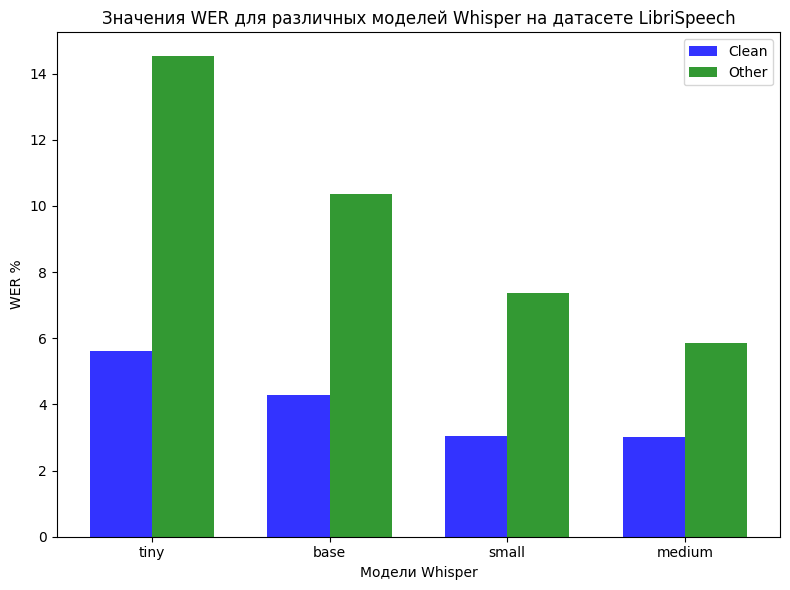

In [ ]:
import matplotlib.pyplot as plt

models = ['tiny', 'base', 'small', 'medium']
clean_wer = [5.60, 4.28, 3.05, 3.02]
other_wer = [14.52, 10.37, 7.38, 5.87]

x = range(len(models))

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(x, clean_wer, bar_width, alpha=opacity, color='b', label='Clean')
rects2 = ax.bar([i + bar_width for i in x], other_wer, bar_width, alpha=opacity, color='g', label='Other')

ax.set_xlabel('Модели Whisper')
ax.set_ylabel('WER %')
ax.set_title('Значения WER для различных моделей Whisper на датасете LibriSpeech')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()
plt.show()

Визуализация анализа датасета из самостоятельно отобранных данных

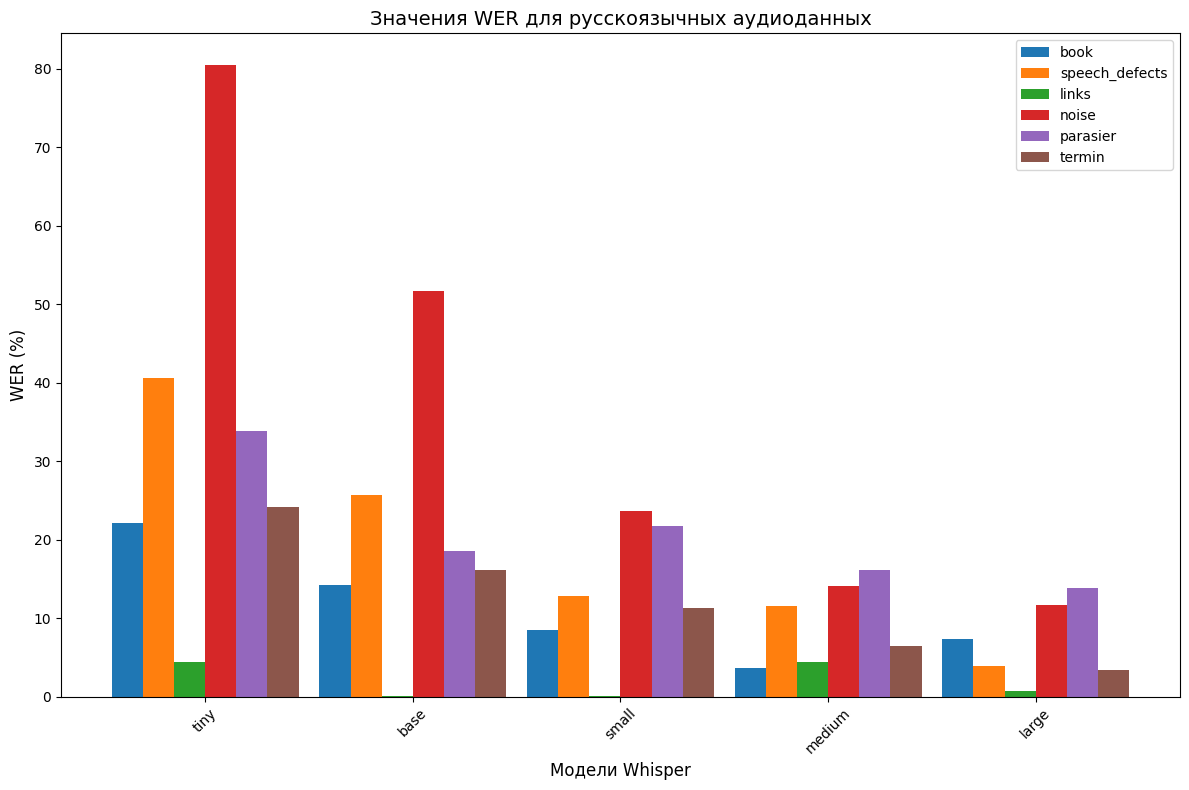

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['tiny', 'base', 'small', 'medium', 'large']
book = [22.11, 14.21, 8.42, 3.68, 7.37]
speech_defects = [40.60, 25.64, 12.82, 11.54, 3.85]
links = [4.35, 0.1, 0.1, 4.35, 0.72]
noise = [80.51, 51.69, 23.66, 14.04, 11.66]
parasier = [33.87, 18.55, 21.77, 16.19, 13.89]
termin = [24.19, 16.13, 11.29, 6.45, 3.41]

x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - 2.5*width, book, width, label='book')
rects2 = ax.bar(x - 1.5*width, speech_defects, width, label='speech_defects')
rects3 = ax.bar(x - 0.5*width, links, width, label='links')
rects4 = ax.bar(x + 0.5*width, noise, width, label='noise')
rects5 = ax.bar(x + 1.5*width, parasier, width, label='parasier')
rects6 = ax.bar(x + 2.5*width, termin, width, label='termin')

ax.set_xlabel('Модели Whisper', fontsize=12)
ax.set_ylabel('WER (%)', fontsize=12)
ax.set_title('Значения WER для русскоязычных аудиоданных', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


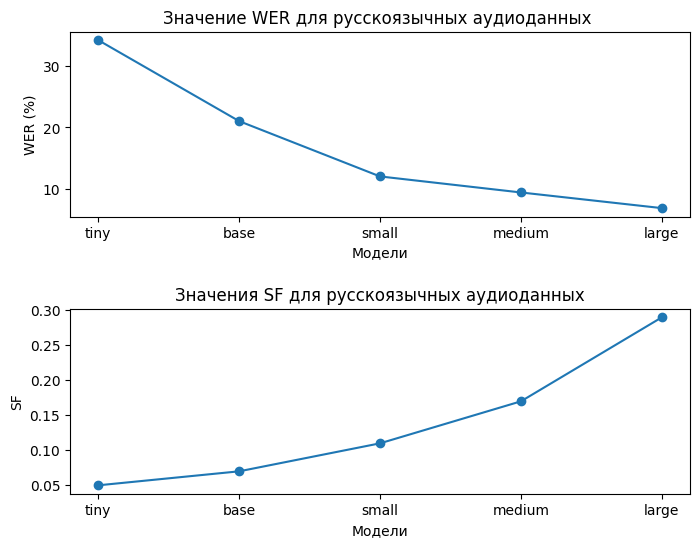

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Данные о WER и SF
models = ['tiny', 'base', 'small', 'medium', 'large']
wer = [34.27, 21.03, 11.99, 9.37, 6.81]
sf = [0.05, 0.07, 0.11, 0.17, 0.29]

# Создание фигуры и осей
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Визуализация WER
ax1.plot(models, wer, marker='o')
ax1.set_xlabel('Модели')
ax1.set_ylabel('WER (%)')
ax1.set_title('Значение WER для русскоязычных аудиоданных ')

# Визуализация SF
ax2.plot(models, sf, marker='o')
ax2.set_xlabel('Модели')
ax2.set_ylabel('SF')
ax2.set_title('Значения SF для русскоязычных аудиоданных')

# Регулировка расстояния между подграфиками
plt.subplots_adjust(hspace=0.5)

# Отображение графика
plt.show()


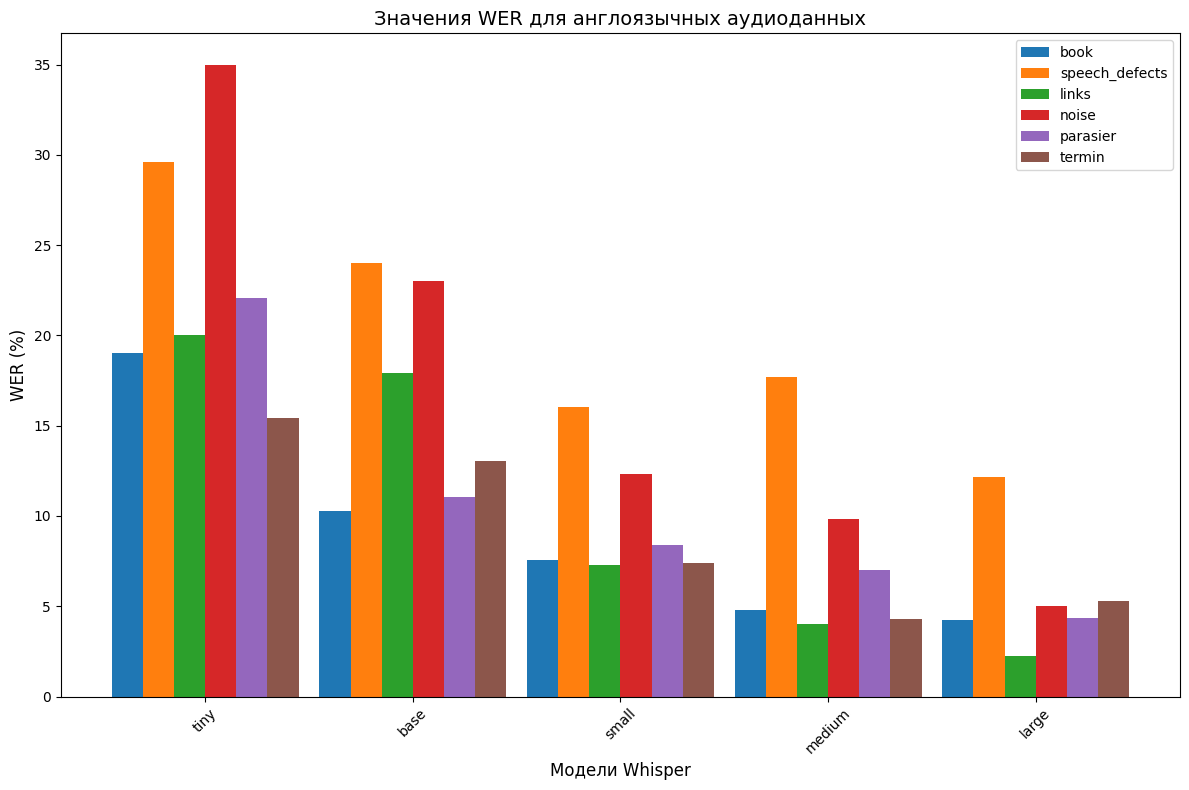

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['tiny', 'base', 'small', 'medium', 'large']
book = [19.03,	10.25,	7.58,	4.79,	4.26]
speech_defects = [29.58,	23.99,	16.05,	17.69,	12.13]
links = [20.03,	17.93,	7.31, 4.04, 2.25]
noise = [34.98,	23.01,	12.3,	9.81,	5.0]
parasier = [22.05,	11.04,	8.37,	7.01,	4.35,]
termin = [15.44,	13.02,	7.37,	4.30,	5.28]

x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - 2.5*width, book, width, label='book')
rects2 = ax.bar(x - 1.5*width, speech_defects, width, label='speech_defects')
rects3 = ax.bar(x - 0.5*width, links, width, label='links')
rects4 = ax.bar(x + 0.5*width, noise, width, label='noise')
rects5 = ax.bar(x + 1.5*width, parasier, width, label='parasier')
rects6 = ax.bar(x + 2.5*width, termin, width, label='termin')

ax.set_xlabel('Модели Whisper', fontsize=12)
ax.set_ylabel('WER (%)', fontsize=12)
ax.set_title('Значения WER для англоязычных аудиоданных', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

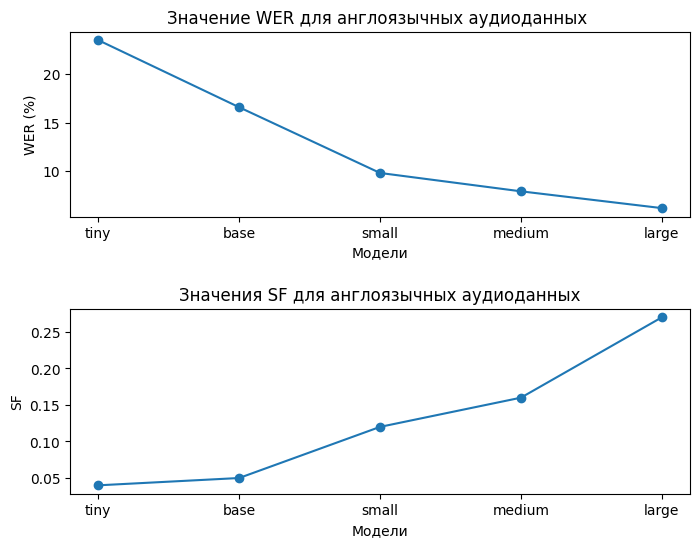

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Данные о WER и SF
models = ['tiny', 'base', 'small', 'medium', 'large']
wer = [23.51,	16.6, 9.83,	7.94,	6.21,]
sf = [0.04,	0.05,	0.12,	0.16,	0.27]

# Создание фигуры и осей
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Визуализация WER
ax1.plot(models, wer, marker='o')
ax1.set_xlabel('Модели')
ax1.set_ylabel('WER (%)')
ax1.set_title('Значение WER для англоязычных аудиоданных ')

# Визуализация SF
ax2.plot(models, sf, marker='o')
ax2.set_xlabel('Модели')
ax2.set_ylabel('SF')
ax2.set_title('Значения SF для англоязычных аудиоданных')

# Регулировка расстояния между подграфиками
plt.subplots_adjust(hspace=0.5)

# Отображение графика
plt.show()